In [267]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'   

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px

from datetime import date, timedelta

import plotly.offline as py

import folium 
from folium import plugins

import warnings
warnings.filterwarnings("ignore") 

import os

## 1. 데이터 불러오기

In [268]:
df = pd.read_csv('https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition.csv', parse_dates=['start', 'end'])

## 2. 데이터 살펴보기

In [269]:
df.shape 

(395547, 8)

- 행 395547개, 열 8개로 이루어진 데이터이다. 

In [5]:
df.head()

,article_id,start,end,answered,votes,category,title,content
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ..."


In [7]:
df.columns 

Index(['article_id', 'start', 'end', 'answered', 'votes', 'category', 'title',
       'content'],
      dtype='object')

- 열 변수로는 article_id(청원 번호), start(청원 시작 날짜), end(청원 마감 날짜), answered(답변 여부, 1=답변됨, 0=답변 안됨), votes(투표 수), category(카테고리), title(청원 제목), content(내용)이 있다.

In [23]:
df.dtypes 

article_id             int64
start         datetime64[ns]
end           datetime64[ns]
answered               int64
votes                  int64
category              object
title                 object
content               object
dtype: object

- start, end는 datetime 변수, article_id, answered, votes는 integer, 나머지는 object

In [6]:
df.isnull().sum() 

article_id    0
start         0
end           0
answered      0
votes         0
category      0
title         0
content       1
dtype: int64

- content 변수에 결측치 한개 있는 것을 확인할 수 있다.

In [270]:
df.iloc[df.content.index[df.content.isnull()==True],:]  

,article_id,start,end,answered,votes,category,title,content
31074,32395,2017-11-11,2017-12-11,0,0,정치개혁,이명박 출국금지 구속수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,NaN


- 31074번째 인덱스(31075번째 행)의 content가 결측치로 들어가있다.

### 2-1. integer 변수

In [9]:
df.describe() 

,article_id,answered,votes
count,395547.000000,395547.000000,3.955470e+05
mean,251608.934635,0.000073,1.501188e+02
std,153219.216242,0.008562,4.802583e+03
min,21.000000,0.000000,0.000000e+00
25%,115236.500000,0.000000,2.000000e+00
50%,253682.000000,0.000000,5.000000e+00
75%,386137.500000,0.000000,1.500000e+01
max,517122.000000,1.000000,1.192049e+06


- integer 변수 article_id, answered, votes의 통계량. 
- answered는 최소값이 0, 최대값이 1. 답변된 경우는 전체 청원의 0.0073%. 

### 2-2. object 변수

In [10]:
df.describe(include=np.object)

,category,title,content
count,395547,395547,395546
unique,17,346524,375224
top,정치개혁,이명박 출국금지,이명박 출국금지
freq,62750,3018,597


- object 변수 category, title, content의 통계량. 
- category는 총 17 종류. 그 중 "정치개혁" 카테고리가 가장 많다.
- title은 총 346524 종류. 그 중 "이명박 출국금지" 제목이 가장 많다. 
- content는 총 375224 종류. 세 object 변수 중 가장 다양성이 크다. 그 중 "이명박 출국금지" 내용이 가장 많다. 

### 2-3. datetime 변수

In [18]:
print(np.min(df.start))
print(np.max(df.start))


2017-08-19 00:00:00
2019-02-04 00:00:00


- start의 최소값은 2017년 8월 19일, 최대값은 2019년 2월 4일이다. 
- 17년 8월 19일 청원부터 19년 2월 4일 청원까지 담긴 데이터임을 알 수 있다. 

In [19]:
print(np.min(df.end))
print(np.max(df.end))

2017-08-26 00:00:00
2019-03-06 00:00:00


- end의 최소값은 2017년 8월 26일, 최대값은 2019년 3월 6일이다. 
- 19년 3월 6일에 종료된 청원까지 담긴 데이터임을 알 수 있다. 

## 3. 데이터 분석

### 1. 청원 기간 duration

#### 1. 청원 기간의 분포

In [271]:
df["duration"]=df["end"]-df["start"]

In [272]:
df.head()

,article_id,start,end,answered,votes,category,title,content,duration
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...,90 days
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...,90 days
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",15 days
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...,7 days
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",15 days


In [273]:
df.tail()

,article_id,start,end,answered,votes,category,title,content,duration
395542,517117,2019-02-04,2019-03-06,0,3,보건복지,명절연휴 고속도로 무료반대,명절고속도로 무료보단 대다수의 서민들이 이용하는 대중교통 무료와 명절기간 증차로 했...,30 days
395543,517119,2019-02-04,2019-03-06,0,23,보건복지,광주사태 가짜 유공자들 정수기로 걸려내야함,광주사태 유공자들 차고 넘치는데 이래 많은 유공자들 그냥놓아두면 재앙이다.\n김대중...,30 days
395544,517120,2019-02-04,2019-03-06,0,0,안전/환경,환경문제,명절이면 후로 제일문제는 쓰레기 문제 입니다.\n제일문제는 선물세트와 농산물세트 입...,30 days
395545,517121,2019-02-04,2019-03-06,0,20,정치개혁,"청화대,더불어민주당, 당장 답하라,,,,,,","좌파 더불어민주당, 좌파 정권 청화대는 선한 국민들을 더는 기망하지 말고 담장 답하...",30 days
395546,517122,2019-02-04,2019-03-06,0,16,인권/성평등,여성부 폐지,국민들이 원합니다\n폐지 좀 시키세요;,30 days


In [274]:
df.groupby("duration").size()

duration
7 days       2436
15 days      1204
30 days    384347
60 days       806
90 days      6754
dtype: int64

In [275]:
df["duration"]=df["duration"].dt.days

Text(0, 0.5, 'Frequency')

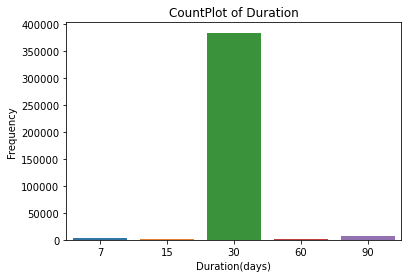

In [276]:
ax = plt.subplots() 
ax = sns.countplot("duration", data=df)
ax.set_title('CountPlot of Duration') 
ax.set_xlabel('Duration(days)')
ax.set_ylabel('Frequency')

- 청원 기간이 가장 짧은 건 7일, 가장 긴 건 90일이다.    
- 청원 수가 가장 많은 기간은 30일이다. 

#### 2. 청원 기간 별 투표 수 비교

In [277]:
votesbyduration=df.groupby("duration").votes
votesbyduration.describe()

,count,mean,std,min,25%,50%,75%,max
duration,,,,,,,,
7,2436.0,47.352627,950.751596,0.0,0.0,0.0,1.0,34318.0
15,1204.0,143.583887,3568.392302,0.0,0.0,0.0,2.0,123204.0
30,384347.0,150.238956,4735.130090,0.0,2.0,5.0,16.0,1192049.0
60,806.0,561.816377,11334.174517,0.0,0.0,0.0,2.0,296330.0
90,6754.0,132.381700,7545.669256,0.0,0.0,0.0,1.0,615354.0


Text(0, 0.5, 'Votes')

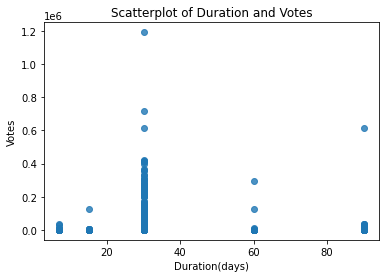

In [278]:
ax = plt.subplots() 
ax = sns.regplot(x='duration', y='votes', data=df, fit_reg=False)
ax.set_title('Scatterplot of Duration and Votes') 
ax.set_xlabel('Duration(days)') 
ax.set_ylabel('Votes') 

- 청원 기간이 길수록 받은 투표 수가 많을 것이라고 예상했으나 꼭 그렇지 않다는 것을 확인할 수 있다. 
- 최대 투표 수는 1192049로 청원 기간이 30일 일때이다. 
- 평균 투표 수가 가장 많은 건 청원 기간이 60일 일때이다. 

### 2. 답변 대상 answer

#### 1. 청원 기간 별 답변 대상, 답변 비율

- 답변 대상이 되기 위해선 20만건 이상의 투표 수를 받아야한다. 
- 청원 기간이 길다고 투표 수가 많은 것이 아니라는 걸 위에서 확인했다. 따라서 청원 기간과 답변 대상이 될 확률이 꼭 비례하진 않을 것이라고 예상해볼 수 있다. 

In [279]:
votes20=df.index[df["votes"]>=200000]
votes20
#투표를 20만건 이상 받아야 답변 대상이 된다. 
#답변 대상이 되는 청원의 인덱스 추출. 

Int64Index([  1752,  10894,  18111,  25032,  43992,  47285,  54896,  70744,
             73197,  74640,  84324,  85497,  89188,  91882,  98134, 106657,
            112158, 117927, 118970, 124216, 124397, 126532, 131327, 137035,
            138242, 144223, 144874, 148359, 154986, 161851, 161950, 163363,
            164274, 175768, 183791, 184529, 186976, 187991, 192426, 193251,
            194822, 208597, 209715, 211110, 211483, 217468, 218365, 219857,
            227227, 242969, 248925, 284574, 295554, 303793, 305013, 305378,
            312931, 313314, 314764, 314823, 315634, 316569, 318234, 320034,
            321042, 327507, 327873, 335887, 336559, 340046, 343587, 345700,
            349254, 355362, 355595, 363005, 375654, 390787, 391208, 391984],
           dtype='int64')

In [280]:
answer=df.iloc[votes20,:]
answer.head()
#답변 대상 되는 청원만 모아서 answer에 저장. 

,article_id,start,end,answered,votes,category,title,content,duration
1752,1785,2017-09-03,2017-11-02,1,296330,인권/성평등,청소년이란 이유로 보호법을 악용하는 잔인무도한 청소년들이 늘어나고있습니다. 반드시 ...,안녕하십니까. 청소년보호법이란 명목하에 나쁜짓을 일삼는 청소년들이 너무나 많아지고 ...,60
10894,10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,90
18111,18278,2017-09-30,2017-10-30,1,235372,인권/성평등,낙태죄 폐지와 자연유산 유도약(미프진) 합법화 및 도입을 부탁드립니다.,안녕하세요. 존경하는 대통령님 의원님\n낙태죄 폐지를 청원합니다.\n현재 대한민국은...,30
25032,26024,2017-11-04,2017-12-04,1,216774,안전/환경,'주취감형(술을 먹으면 형벌 감형)' 폐지를 건의(청원)합니다.,"'주취감형'이란, 술을 먹고 범행을 저지를 때, 심신미약 (이성이 없고 우발적)이라...",30
43992,45581,2017-11-17,2017-12-17,1,281985,보건복지,"권역외상센터 (이국종 교수님) 추가적, 제도적, 환경적, 인력 지원","청원사항)\n중증외상분야의 추가적, 제도적, 환경적, 인력 지원 방안마련\n현 의료...",30


In [281]:
answer.groupby("duration").size()

duration
30    78
60     1
90     1
dtype: int64

- 청원기간이 30, 60, 90일인 경우만 청원 대상이 되었다. 
- 7, 15일인 경우는 청원 대상이 될만큼 충분한 투표 수를 얻지 못했다. 충분한 투표 수를 얻기엔 기간이 짧았던 것이라고 예측할 수 있다.

In [282]:
answer.groupby("duration").answered.mean()

duration
30    0.346154
60    1.000000
90    1.000000
Name: answered, dtype: float64

- 답변된 경우 answered=1 이기 때문에 청원 기간 별 answered의 평균을 보면 답변 대상이 된 청원 중 답변된 청원의 비율을 알 수 있다. 
- 청원 기간이 60, 90일인 경우 답변 대상이 된 청원은 하나씩이었고 둘 다 모두 답변된 것을 확인할 수 있다. 
- 그에 비해 30일인 경우 답변 대상이 된 청원 중 34.6%만 답변된 것을 확인할 수 있다. 

In [283]:
answer30=df.index[(df["duration"]==30)&(df["answered"]==1)]
df.iloc[answer30]
#청원기간 30일 중 답변된 청원. 

,article_id,start,end,answered,votes,category,title,content,duration
18111,18278,2017-09-30,2017-10-30,1,235372,인권/성평등,낙태죄 폐지와 자연유산 유도약(미프진) 합법화 및 도입을 부탁드립니다.,안녕하세요. 존경하는 대통령님 의원님\n낙태죄 폐지를 청원합니다.\n현재 대한민국은...,30
25032,26024,2017-11-04,2017-12-04,1,216774,안전/환경,'주취감형(술을 먹으면 형벌 감형)' 폐지를 건의(청원)합니다.,"'주취감형'이란, 술을 먹고 범행을 저지를 때, 심신미약 (이성이 없고 우발적)이라...",30
43992,45581,2017-11-17,2017-12-17,1,281985,보건복지,"권역외상센터 (이국종 교수님) 추가적, 제도적, 환경적, 인력 지원","청원사항)\n중증외상분야의 추가적, 제도적, 환경적, 인력 지원 방안마련\n현 의료...",30
47285,49083,2017-11-24,2017-12-24,1,211064,기타,"전안법. 18살, 미성년자에게 정부가 직접 찍어주는 범죄자 낙인!","3년 이하의 징역, 또는3천만원 이하의 벌금. 혹은 500만원 이하의 과태료.\n설...",30
54896,57132,2017-12-03,2018-01-02,1,255554,성장동력,전안법 합리적으로 개정 또는 폐지해주세요.(소상공인 소비자 모두 죽는법안입니다.),2017년 1월 28일부터 시행되는 법령으로 국가기술표준원에서 관리하는 전기제품에만...,30
70744,76020,2017-12-28,2018-01-27,1,228295,성장동력,<가상화폐규제반대> 정부는 국민들에게 단 한번이라도 행복한 꿈을 꾸게 해본적 있습니까?,저는 정부에게 묻고 싶습니다.\n정부는 단 한번이라도 우리 국민들에게 행복한 꿈을 ...,30
73197,79162,2018-01-03,2018-02-02,1,233842,인권/성평등,미성년자 성폭행 형량 올려주세요 종신형원합니다,또 창원에서 조두순사건과 같은 사건이 발생했네요\n술먹어 심신이 미약하신 50대 대...,30
74640,81026,2018-01-06,2018-02-05,1,213219,인권/성평등,초.중.고 학교 페미니즘교육 의무화,아직 판단이 무분별한 어린학생들이 학교에서 여성비하적요소가 들어있는 단어들을 아무렇...,30
84324,95138,2018-01-14,2018-02-13,1,219395,교통/건축/국토,대전 아파트 단지내 횡단보도 교통사고..가해자의 만행과 도로교통법의 허점,1. 2017년 10월 16일 19시10분경 대전 맑은 아침 아파트 단지 내 횡단보...,30
85497,96427,2018-01-15,2018-02-14,1,277674,정치개혁,국회의원 급여를 최저시급으로 책정해 주세요,최저시급 인상 반대하던 의원들부터 최저시급으로 책정해주시고 최저시급으로 일하는 노동...,30


In [284]:
answer60=df.index[(df["duration"]==60)&(df["answered"]==1)]
df.iloc[answer60]
#청원기간 60일 중 답변된 청원. 

,article_id,start,end,answered,votes,category,title,content,duration
1752,1785,2017-09-03,2017-11-02,1,296330,인권/성평등,청소년이란 이유로 보호법을 악용하는 잔인무도한 청소년들이 늘어나고있습니다. 반드시 ...,안녕하십니까. 청소년보호법이란 명목하에 나쁜짓을 일삼는 청소년들이 너무나 많아지고 ...,60


In [285]:
answer90=df.index[(df["duration"]==90)&(df["answered"]==1)]
df.iloc[answer90]
#청원기간 90일 중 답변된 청원. 

,article_id,start,end,answered,votes,category,title,content,duration
10894,10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,90


#### 2. 답변 대상 중 투표 수가 답변 여부에 영향을 미치는지 

- 답변 대상 중 '답변 받은 청원의 투표 수'와 '답변 받지 못한 청원의 투표 수'를 비교해봐서 투표 수가 답변 여부에 영향을 미치는지 알아본다. 

In [286]:
yes=answer[answer["answered"]==1]
no=answer[answer["answered"]==0]

In [287]:
yes.votes.describe()

count        29.000000
mean     280025.689655
std      108390.808396
min      201590.000000
25%      217054.000000
50%      235372.000000
75%      281985.000000
max      615354.000000
Name: votes, dtype: float64

In [288]:
no.votes.describe()

count    5.100000e+01
mean     2.817428e+05
std      1.558871e+05
min      2.025480e+05
25%      2.144700e+05
50%      2.334950e+05
75%      2.903815e+05
max      1.192049e+06
Name: votes, dtype: float64

In [289]:
print("answered votes min:", yes.votes.min(), "\nnot answered votes min:", no.votes.min())
print("answered votes mean:", yes.votes.mean(), "\nnot answered votes mean:", no.votes.mean())
print("answered votes max:", yes.votes.max(), "\nnot answered votes max:", no.votes.max())

answered votes min: 201590 
not answered votes min: 202548
answered votes mean: 280025.6896551724 
not answered votes mean: 281742.8039215686
answered votes max: 615354 
not answered votes max: 1192049


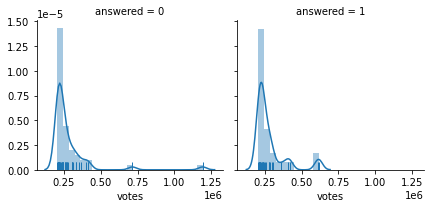

In [290]:
facet = sns.FacetGrid(answer, col='answered') 
facet.map(sns.distplot, 'votes', rug=True) 

- 투표수는 답변 여부에 큰 영향을 미치지 않음을 알 수 있다. 
- 오히려 답변 받지 못한 청원의 최대 투표수는 답변 받은 청원의 최대 투표수의 거의 두배가 되는걸 확인할 수 있다. 

In [291]:
nomax=no.votes.max()
no[no["votes"]==nomax]

,article_id,start,end,answered,votes,category,title,content,duration
313314,408609,2018-10-17,2018-11-16,0,1192049,안전/환경,강서구 피시방 살인 사건. 또 심신미약 피의자입니다.,2018년 10월 14일 엊그제 일어난 강서구 피시방 살인사건에 대한 청원입니다.\...,30


- 답변을 받지 못한 청원 중 투표 수가 가장 많은 청원은 "강서구 피시방 살인 사건. 또 심신미약 피의자입니다."이다. 

In [292]:
yesmax=yes.votes.max()
yes[yes["votes"]==yesmax]

,article_id,start,end,answered,votes,category,title,content,duration
10894,10949,2017-09-06,2017-12-05,1,615354,미래,조두순 출소반대,제발 조두순 재심다시해서 무기징역으로 해야됩니다!!!,90


- 답변을 받은 청원 중 투표 수가 가장 많은 청원은 "조두순 출소반대"이다. 

### 2. 카테고리 category

In [293]:
pd.value_counts(df["category"])

정치개혁           62750
기타             48682
인권/성평등         34993
안전/환경          30638
교통/건축/국토       28184
외교/통일/국방       26626
육아/교육          25537
보건복지           24848
일자리            23225
행정             20268
문화/예술/체육/언론    18207
미래             18000
경제민주화          16793
성장동력            7253
반려동물            4057
저출산/고령화대책       3584
농산어촌            1902
Name: category, dtype: int64

In [294]:
def pie_chart(data, col, title = ''): 
    cnt_df = data[col].value_counts().reset_index() 

    fig = px.pie(cnt_df, 
                 values = col, 
                 names = 'index', 
                 title = title, 
                 template = 'seaborn', 
                 color_discrete_sequence=px.colors.sequential.RdBu) #파이 색깔
    fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")

    fig.show()

In [295]:
pie_chart(df, "category", title=" ")

- "정치개혁" 카테고리에 가장 많은 청원이 올라왔음을 알 수 있다. 
- 기타 카테고리를 제외하면 그 다음으로 많은 건 "인권/성평등", "안전/환경"이다. 

#### 1. 카테고리 별 투표 수 

In [296]:
df.groupby("category").votes.describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
경제민주화,16793.0,103.589591,2898.089407,0.0,2.0,6.0,20.0,242286.0
교통/건축/국토,28184.0,102.977931,3244.679563,0.0,2.0,6.0,18.0,406655.0
기타,48682.0,106.619859,3765.557406,0.0,1.0,4.0,11.0,354935.0
농산어촌,1902.0,62.497897,620.175780,0.0,1.0,3.0,7.0,15603.0
문화/예술/체육/언론,18207.0,227.923106,6346.157959,0.0,2.0,5.0,16.0,614127.0
미래,18000.0,63.371833,4606.840886,0.0,1.0,4.0,12.0,615354.0
반려동물,4057.0,509.397091,7435.869951,0.0,6.0,16.0,38.0,226252.0
보건복지,24848.0,174.710681,3559.078493,0.0,2.0,6.0,16.0,281985.0
성장동력,7253.0,120.203640,4177.029097,0.0,1.0,3.0,9.0,255554.0


- 가장 많은 투표 수를 받은 카테고리는 "안전/환경"이다. 
- 평균적으로 가장 많은 투표 수를 받은 카테고리는 "반려동물"이다. 전체 청원 중 1.03%만 차지하지만 평균 투표 수는 가장 많다. 이는 해당 카테고리에 올라온 청원 수는 적지만 그 청원의 대부분이 공감을 많이 얻었다고 볼 수 있다. 

#### 2. 답변 대상 청원의 카테고리 별 비율

In [297]:
df["answer"] = df["votes"]>=200000
df["answer"] = df["answer"].astype("int")
df.head()

,article_id,start,end,answered,votes,category,title,content,duration,answer
0,21,2017-08-19,2017-11-17,0,9,안전/환경,스텔라 데이지호에 대한 제안입니다.,스텔라 데이지호에 대한 제안입니다.\n3월31일 스텔라 데이지호가 침몰하고 5달째가...,90,0
1,22,2017-08-19,2017-11-17,0,17,기타,비리제보처를 만들어주세요.,현 정부에 국민들이 가장 원하는 것은 부패척결입니다. 우리 사회에 각종 비리들이 ...,90,0
2,23,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",15,0
3,24,2017-08-19,2017-08-26,0,53,일자리,공공기관 무조건적인 정규직전환을 반대합니다.,현정부에서 정규직 일자리를 늘리는 것에 찬성합니다. 그런데 공공기관 비정규직들은 인...,7,0
4,25,2017-08-19,2017-09-03,0,0,미래,제2의 개성공단,"만일 하시는 대통령님 및 각 부처 장관님,주무관님들 안녕하세요!!\n전남 목포에서 ...",15,0


In [298]:
answer.groupby("category").size()

category
경제민주화           2
교통/건축/국토        3
기타              8
문화/예술/체육/언론     7
미래              1
반려동물            4
보건복지            3
성장동력            2
안전/환경          10
외교/통일/국방        4
육아/교육           3
인권/성평등         24
정치개혁            8
행정              1
dtype: int64

In [299]:
pie_chart(answer, "category", title="답변 대상 청원")

- 답변 대상 청원 중 가장 비율이 높은 카테고리는 "인권/성평등"이고 그 다음은 "안전/환경"이다. 
- 전체 청원 중 8.85%를 차지한 "인권/성평등"이 답변 대상 청원 중에서는 30%를 차지한 점을 보아 많은 국민이 공감하는 카테고리임을 알 수 있다. 
- 반대로 전체 청원 중 가장 많은 비율을 차지한 "정치개혁"은 답변 대상 청원 중 10%를 차지한 점을 보아 국민의 의견이 나뉘는 카테고리임을 알 수 있다. 

#### 3. 답변된 청원의 카테고리 별 비율

In [300]:
df[df["answered"]==1].groupby("category").size()

category
경제민주화          1
교통/건축/국토       2
기타             1
문화/예술/체육/언론    4
미래             1
보건복지           2
성장동력           2
안전/환경          2
외교/통일/국방       1
육아/교육          1
인권/성평등         9
정치개혁           2
행정             1
dtype: int64

In [301]:
pie_chart(df[df["answered"]==1], "category", title="답변 완료 청원")

- 답변된 청원 중 가장 비율이 높은건 "인권/성평등" 이고 그 다음은 "문화/예술/체육/언론"이다. 
- "인권/성평등" 카테고리가 답변 대상 청원의 30%, 답변 완료 청원의 31%를 차지한 점을 보아 국민과 정부 모두 인권/성평등 분야에 있어서 관심이 높고 비슷한 의견을 가지고 있다고 볼 수 있다. 

#### 4. 답변되지 않은 답변 대상 청원의 카테고리 별 비율

In [302]:
answer[answer["answered"]==0].groupby("category").size()

category
경제민주화           1
교통/건축/국토        1
기타              7
문화/예술/체육/언론     3
반려동물            4
보건복지            1
안전/환경           8
외교/통일/국방        3
육아/교육           2
인권/성평등         15
정치개혁            6
dtype: int64

In [303]:
pie_chart(answer[answer["answered"]==0], "category", title="답변 안된 청원")

- 답변 안된 답변 대상 청원 중 가장 비율이 높은건 "인권/성평등" 이고 그 다음은 "안전/환경"이다. 
- "인권/성평등" 카테고리는 답변된 청원과 답변 되지 않은 청원 모두 많다. 해당 카테고리에 많은 국민은 공감하지만 정부는 동의하지 않는 청원이 꽤 올라온다고 예측할 수 있다.  

#### 5. 카테고리 별 답변 비율

In [304]:
df.groupby("category").answered.mean().sort_values(ascending=False)

category
성장동력           0.000276
인권/성평등         0.000257
문화/예술/체육/언론    0.000220
보건복지           0.000080
교통/건축/국토       0.000071
안전/환경          0.000065
경제민주화          0.000060
미래             0.000056
행정             0.000049
육아/교육          0.000039
외교/통일/국방       0.000038
정치개혁           0.000032
기타             0.000021
반려동물           0.000000
일자리            0.000000
농산어촌           0.000000
저출산/고령화대책      0.000000
Name: answered, dtype: float64

- 전체 청원 중 답변을 받은 비율이 가장 높은 카테고리는 "성장동력"이고 그 다음은 "인권/성평등", "문화/예술/체육/언론"이다.
- 정치개혁 카테고리에 청원이 가장 많았음에도 불구하고 해당 카테고리의 답변 비율은 낮은 편에 속한다. 

### 3. 월별 month

In [305]:
df["month"]=df["start"].dt.month

#### 1. 월별 청원 수 비교

In [306]:
pd.value_counts(df.month)

1     52941
11    52847
9     40888
12    38498
10    31687
8     28851
2     28117
7     25714
5     25499
6     25483
4     23227
3     21795
Name: month, dtype: int64

Text(0, 0.5, 'Number of petition')

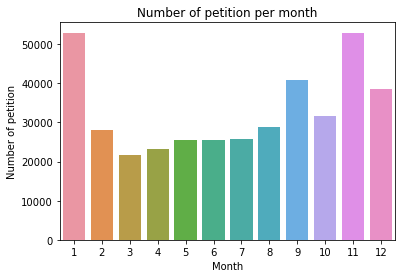

In [307]:
ax = plt.subplots() 
ax = sns.countplot('month', data=df)  
ax.set_title('Number of petition per month') 
ax.set_xlabel('Month') 
ax.set_ylabel('Number of petition') 

- 1월에 청원 수가 가장 많았고 11월에 그 다음으로 많았다. 

#### 2. 월별 투표 수 비교

In [308]:
monthlyvote=df.groupby("month")["votes"].agg(["mean","max"])
monthlyvote

,mean,max
month,,
1,128.586842,360905
2,140.267952,614127
3,187.132920,304320
4,174.765359,302082
5,205.935292,419006
6,182.327002,714875
7,160.298631,413924
8,82.012825,176493
9,107.904446,615354


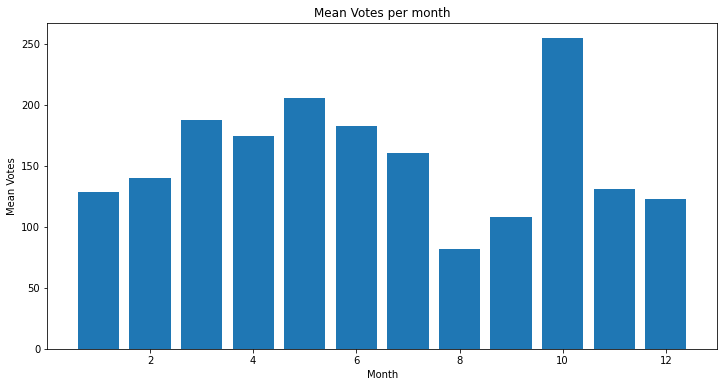

In [309]:
plt.figure(figsize=(12,6))
plt.bar(x=monthlyvote.index, height=monthlyvote["mean"])

plt.title('Mean Votes per month') 
plt.xlabel('Month') 
plt.ylabel('Mean Votes') 
plt.show()

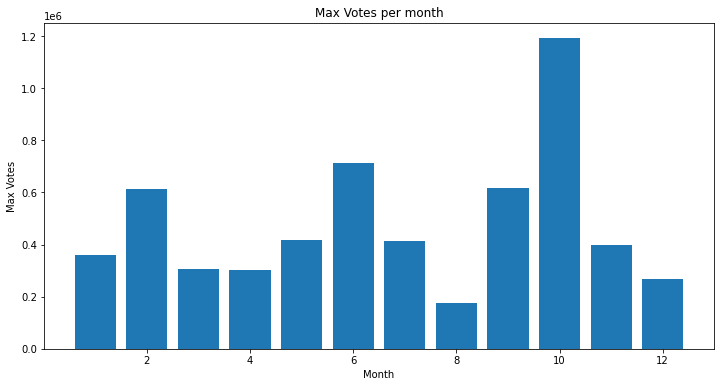

In [310]:
plt.figure(figsize=(12,6))
plt.bar(x=monthlyvote.index,height=monthlyvote["max"])

plt.title('Max Votes per month') 
plt.xlabel('Month') 
plt.ylabel('Max Votes') 
plt.show()

- 투표 수는 10월에 가장 많았다. 
- 참고로 해당 청원은 위에서 구한 "답변을 받지 못한 청원 중 투표 수가 가장 많았던 청원"이다. 
- 올라온 청원 수가 많다고해서 그 달에 투표 수가 많은 것은 아니다. 
- 오히려 청원 수가 많았던 11월과 1월은 투표 수가 적다. 